In [220]:
import boruta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import Bunch
%matplotlib inline

In [221]:
df = pd.read_csv('data/wine.csv')
X = df.drop('quality', axis=1).values
y = df['quality'].values
feature_names = df.drop('quality', axis=1).columns.tolist()
target_names = sorted(df['quality'].unique())
comp_data = Bunch(
    data=Bunch(
        data=X,
        target=y,
        feature_names=feature_names,
        target_names=target_names
    )
)
X = comp_data.data.data
feature_names = comp_data.data.feature_names
target_names = comp_data.data.target_names

In [222]:
train, test, labels_train, labels_test = train_test_split(comp_data.data.data, comp_data.data.target, train_size=0.80)

In [223]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state= 42)
rf.fit(train, labels_train)
mean_accuracy = rf.score(test, labels_test)
mean_accuracy

0.8887755102040816

In [224]:
from explainer_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(train,   mode="classification", feature_names=feature_names,
                                 class_names=target_names, discretize_continuous=True,  verbose=False, random_state= 42)

In [225]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering().fit(X)
names = list(feature_names)+["membership"]
clustered_data = np.column_stack([X, clustering.labels_])
print("Clustered Data Shape:", clustered_data.shape)

Clustered Data Shape: (4898, 12)


In [226]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(train)
distances, indices = nbrs.kneighbors(test)
clabel = clustering.labels_

In [227]:
x = 5
data_test = test[x].reshape(1, -1)
prediction = rf.predict(data_test)[0]
y_true = np.array(labels_test)[x]
print(f"Sample {x} from the test set, predicted as {prediction}, true label is {y_true}") 

Sample 5 from the test set, predicted as bad, true label is bad


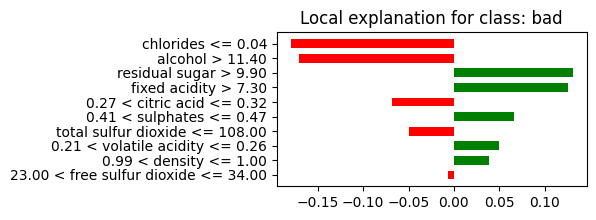

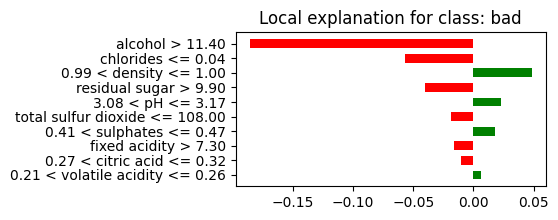

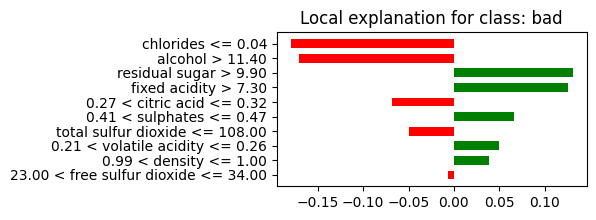

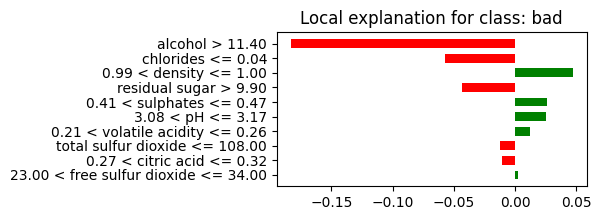

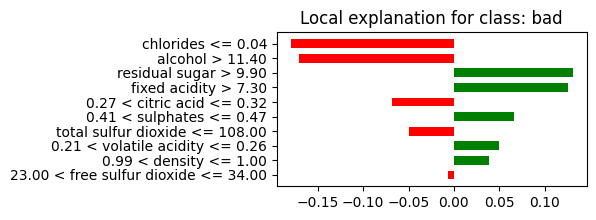

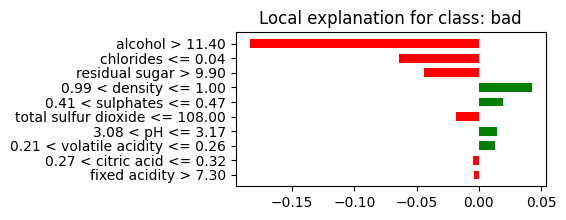

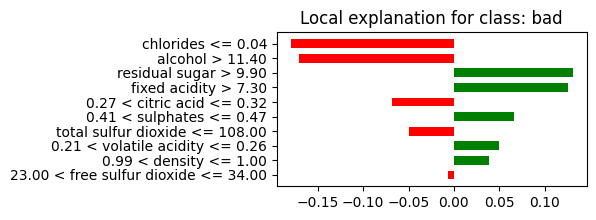

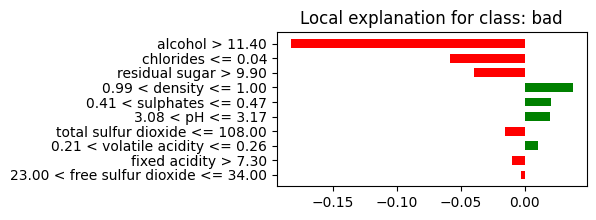

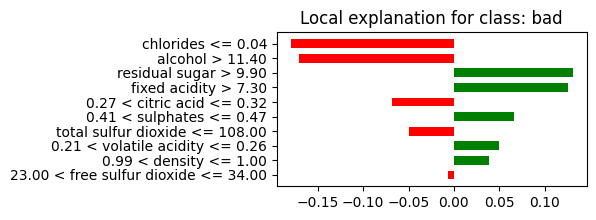

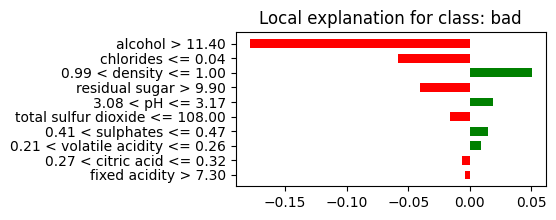

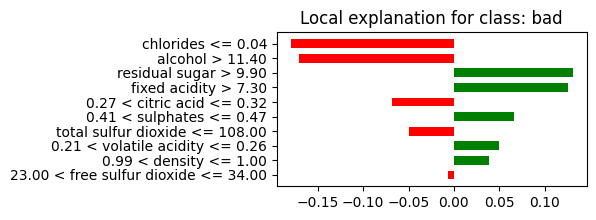

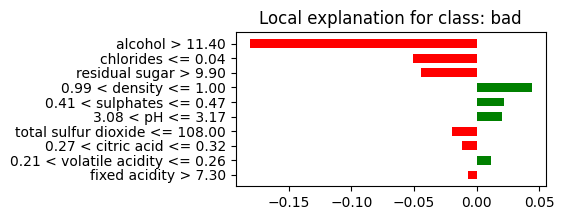

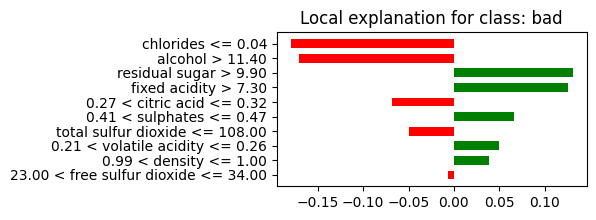

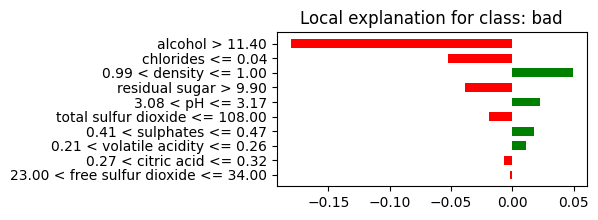

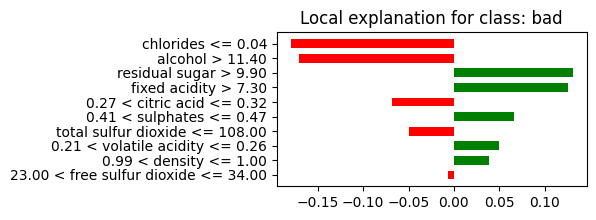

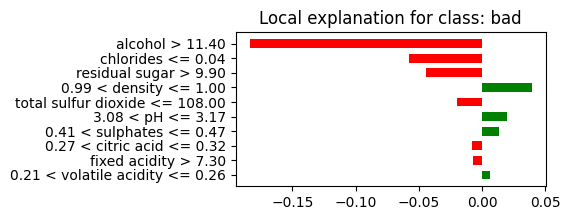

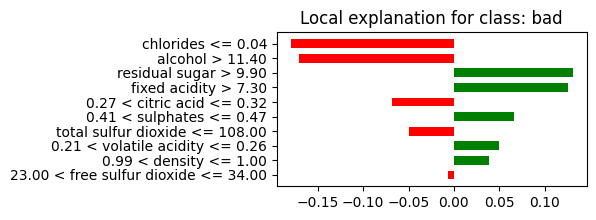

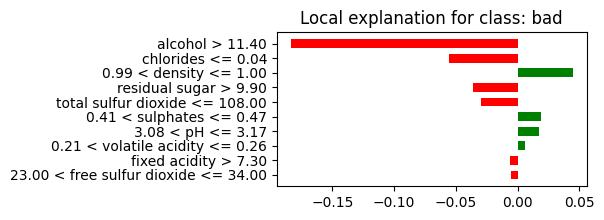

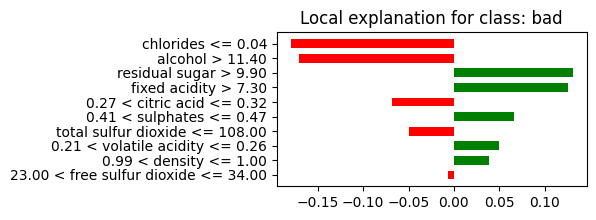

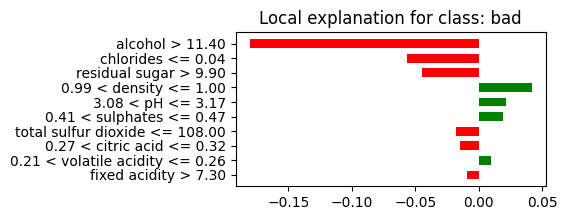

In [228]:
from sklearn.linear_model import LinearRegression
dlime_exp = []
lime_exp = []

for i in range(0, 10):
        p_label = clabel[indices[x]]
        N = clustered_data[clustered_data[:, 11] == p_label]
        subset = np.delete(N, 11, axis=1)

        exp_dlime = explainer.explain_instance_hclust(test[x],
                                             rf.predict_proba,
                                             num_features=10,
                                             model_regressor=LinearRegression(),
                                             clustered_data = subset,
                                             regressor = 'linear', explainer='dlime', labels=(0,1))

        fig_dlime, r_features = exp_dlime.as_pyplot_to_figure(type='h', name = i+.2, label='0') 
                                             #this label is used for the titel and is set manual by hand with 0 and 1
        dlime_exp.append(r_features)


        exp_lime = explainer.explain_instance_hclust(test[x],
                                             rf.predict_proba,
                                             num_features=10,
                                             model_regressor= LinearRegression(),
                                             regressor = 'linear', explainer = 'lime', labels=(0,1))

        fig_lime, r_features = exp_lime.as_pyplot_to_figure(type='h', name = i+.3, label='0')
        #fig_lime.show()
        lime_exp.append(r_features)